Upload libraries

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import joblib

In [3]:
# Read Data
data = pd.read_csv('/content/Original_Scraping_DataSet.csv')
print(data.head())

                                                name       price  \
0  NIVEA Gel Nettoyant Purifiant - Peaux mixtes à...   85.00 Dhs   
1  NIVEA Démaquillant yeux - Double Action - 2x125ml   80.00 Dhs   
2  Now Foods Omega 3 Fish Oil,180 mg d'EPA/120 mg...  190.00 Dhs   
3  NutriPulse Probiotiques Colon Plus 5 billion C...  110.00 Dhs   
4  L'Oréal Paris Offre Spéciale Hyaluron Expert S...  122.00 Dhs   

  original_price discount  review_count seller availability  \
0     167.00 Dhs      49%           4.0  Jumia    Available   
1     145.00 Dhs      45%           4.6  Jumia    Available   
2     312.90 Dhs      39%           4.1  Jumia    Available   
3     192.82 Dhs      43%           3.6  Jumia    Available   
4     152.00 Dhs      20%           3.9  Jumia    Available   

                           badges  \
0  ['Boutique Officielle', '49%']   
1  ['Boutique Officielle', '45%']   
2                         ['39%']   
3                         ['43%']   
4  ['Boutique Officielle', 

Data Cleaning

In [4]:
print(data.shape)

(2153, 10)


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2153 entries, 0 to 2152
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            2153 non-null   object 
 1   price           2153 non-null   object 
 2   original_price  1921 non-null   object 
 3   discount        1921 non-null   object 
 4   review_count    2153 non-null   float64
 5   seller          2153 non-null   object 
 6   availability    2153 non-null   object 
 7   badges          2153 non-null   object 
 8   link            2153 non-null   object 
 9   category        2153 non-null   object 
dtypes: float64(1), object(9)
memory usage: 168.3+ KB
None


In [6]:
# Check the missing values
print(data.isnull().sum())

name                0
price               0
original_price    232
discount          232
review_count        0
seller              0
availability        0
badges              0
link                0
category            0
dtype: int64


In [7]:
# Check the duplicated
print(data.duplicated().sum())

358


In [8]:
# Delete Duplicated Vulues
data = data.drop_duplicates()

In [9]:
# Convert the price column (of type object) to type float, removing non-numeric characters
data["price"] = (
    data["price"]
    .str.replace("Dhs", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.replace(" ", "", regex=False)
    .str.strip()
    .apply(lambda x: x.split('-')[0])
    .astype(float)
)

In [10]:
# Convert the original_price column (of type object) to type float, removing non-numeric characters
data['original_price'] = (
    data['original_price']
    .astype(str)
    .str.replace("Dhs", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.replace(" ", "", regex=False)
    .str.strip()
    .apply(lambda x: x.split('-')[0])
    .astype(float)
)

In [11]:
# removing % from column discount
data["discount"] = (
    data["discount"]
    .str.replace("%", "", regex=False)
    .str.replace(" ", "", regex=False)
    .str.strip()
    .astype(float)
)

In [12]:
# Extract from the column badges containing the contents (official store and discount) and put them in a new column called official store
data['badges'] = data['badges'].apply(ast.literal_eval)

data['official_store'] = data['badges'].apply(
    lambda x: 1 if 'Boutique Officielle' in x else 0
)

In [13]:
# Drop culumns
data.drop(columns=['name','seller', 'availability', 'badges', 'link'], inplace=True)

In [14]:
print(data.columns)

Index(['price', 'original_price', 'discount', 'review_count', 'category',
       'official_store'],
      dtype='object')


In [23]:
# Fill in the missing values with the mean
for i in ['original_price', 'discount']:
  data[i].fillna(data[i].mean())

In [24]:
# Check the missing values
print(data.isnull().sum())

price             0
original_price    0
discount          0
review_count      0
category          0
official_store    0
dtype: int64


In [25]:
# Detect outliers
columns_to_check = ['price', 'original_price', 'discount', 'review_count']

for col in columns_to_check:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    data = data[(data[col] >= lower) & (data[col] <= upper)]

Data Visualization

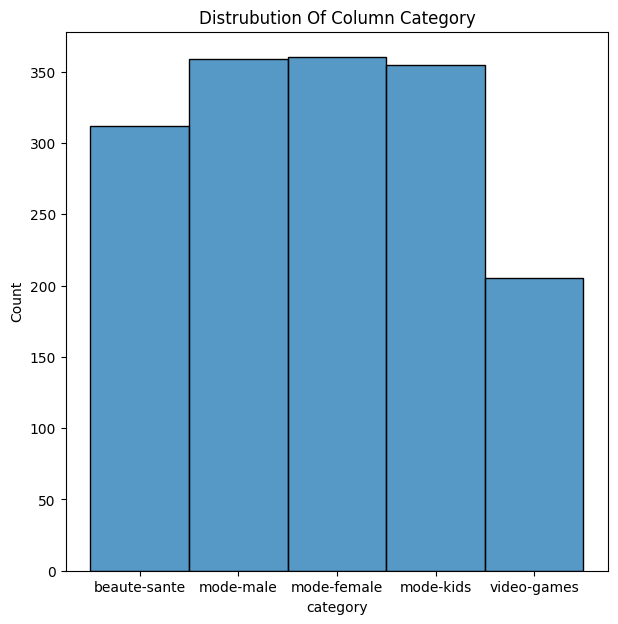

In [27]:
plt.figure(figsize=(7,7))
plt.title('Distrubution Of Column Category')
sns.histplot(data['category'])
plt.show()

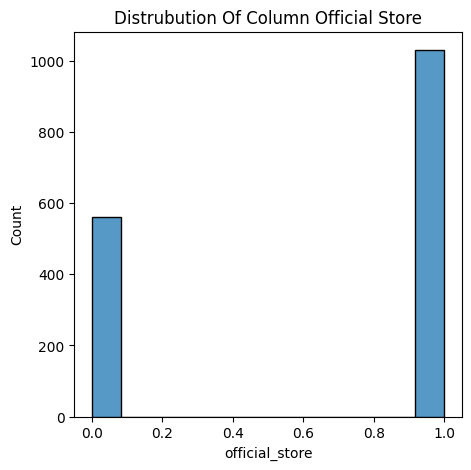

In [35]:
plt.figure(figsize=(5,5))
plt.title('Distrubution Of Column Official Store')
sns.histplot(data['official_store'])
plt.show()

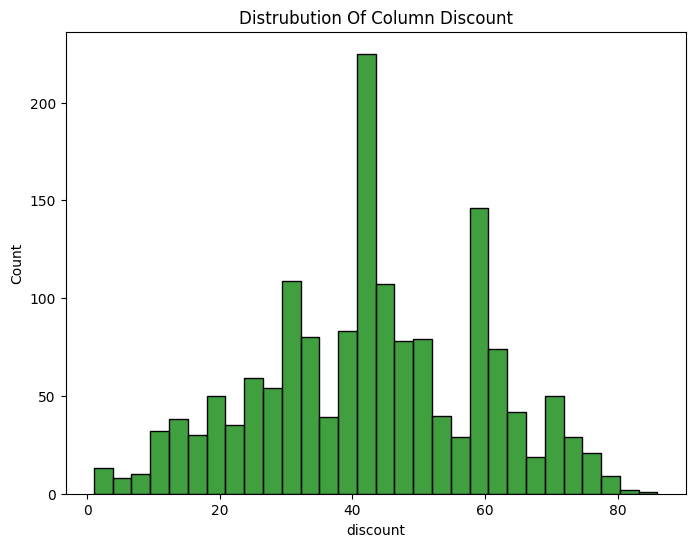

In [36]:
plt.figure(figsize=(8,6))
plt.title('Distrubution Of Column Discount')
sns.histplot(data['discount'], bins=30, color='green')
plt.show()

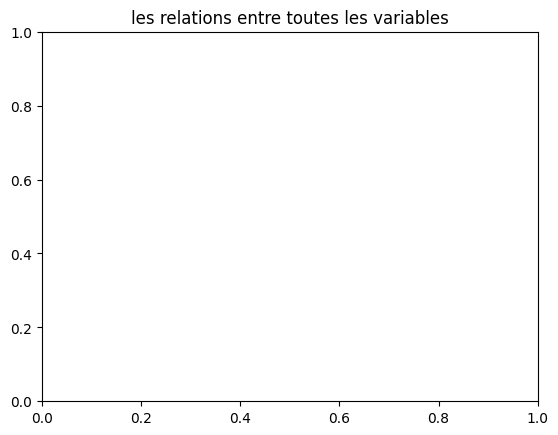

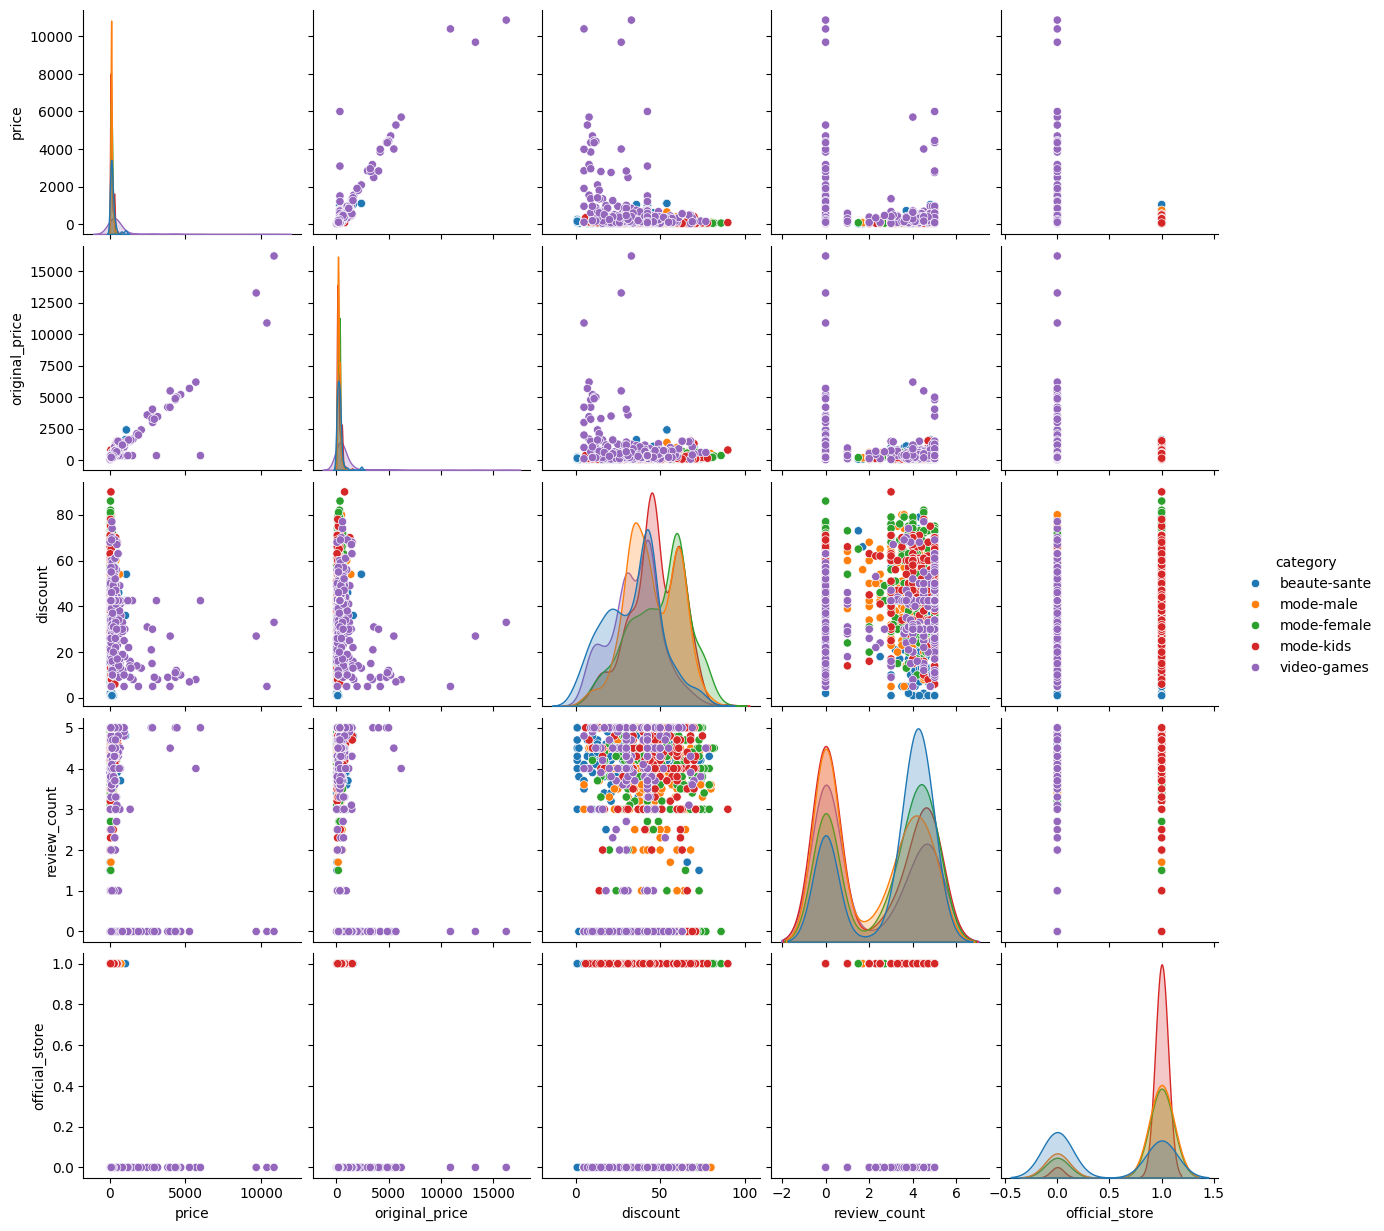

In [83]:
plt.title('les relations entre toutes les variables')
sns.pairplot(data, hue='category')
plt.show()

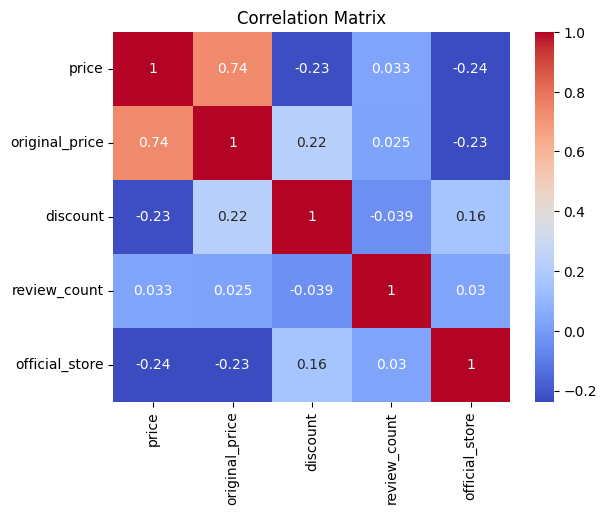

In [28]:
# Correlation Matrix
corr = data[['price', 'original_price','discount','review_count','official_store']].corr()
plt.title('Correlation Matrix')
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

Machine Learning

In [29]:
# convert column category from text into numerique
encoder = LabelEncoder()
data['category'] = encoder.fit_transform(data['category'])

In [30]:
# Split Data Into Train & Test
x = data.drop('price', axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [31]:
#scaler the data
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

Train Model

In [50]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'KNN': KNeighborsRegressor()
}

results = []

In [51]:
for name, model in models.items():
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    r2 = r2_score(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    mae = mean_absolute_error(y_test, prediction)

    results.append({
        'model': name,
        'r2_score': r2,
        'mean_squared_error': mse,
        'mean_absolute_error': mae
    })

In [53]:
# Save result
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='r2_score', ascending=False))

               model  r2_score  mean_squared_error  mean_absolute_error
1      Random Forest  0.842080         1115.634278            11.560491
4                KNN  0.830043         1200.672248            14.050897
2  Gradient Boosting  0.820181         1270.340240            15.162972
3      Decision Tree  0.789458         1487.386591            13.253707
0  Linear Regression  0.687795         2205.592850            29.586618


GridSearchCV

In [59]:
# Parametere
gb_model = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


In [60]:
# Aplly Grid_Search
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)


In [61]:
# Print Best Parameter & R2_score
grid_search.fit(X_train, y_train)

print('Best parameter:'   ,grid_search.best_params_) # Best parameter
print('best result of R2:', grid_search.best_score_)  # best result of R2

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameter: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
best result of R2: 0.844794996154374


In [62]:
# Train Model On Best Parameteres
best_model = grid_search.best_estimator_
pred       = best_model.predict(X_test)

# Print Results
print("🧪 R2_score"            , r2_score(y_test, pred))
print("🧮 mean_squared_error:" , mean_squared_error(y_test, pred))
print("📉 mean_absolute_error:" , mean_absolute_error(y_test, pred))

🧪 R2_score 0.8380126633009171
🧮 mean_squared_error: 1144.3684549031761
📉 mean_absolute_error: 12.20207865422854


In [66]:
# Save Cleaning Data & StandardScaler & Model
data.to_csv('Cleaning_DataSet.csv', index=False)   # Save Cleaning Data
joblib.dump(scaler, 'StandardScaler.pkl')          # Save StandardScaler
joblib.dump(best_model, 'Model.pkl')               # Save Model